## Loan Default Prediction using Deep Neural Networks with ADASYN

### 1. Import Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import ADASYN
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Visualization Setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

### 2. Load Dataset
get CSV from https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv

In [ ]:
df = pd.read_csv("loan.csv")

### 3. Exploratory Data Analysis (EDA)

#### 3.1. Dataset Information

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


#### 3.2. Descriptive Statistics

In [6]:
numerical_cols_for_describe = df.select_dtypes(include=np.number).columns.tolist()
describe_df = df[numerical_cols_for_describe].describe().T
describe_df

,count,mean,std,min,25%,50%,75%,max
id,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
member_id,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,2260668.000000,15046.931228,9190.245488,500.000000,8000.000000,12900.000000,20000.000000,40000.000000
funded_amnt,2260668.000000,15041.664057,9188.413022,500.000000,8000.000000,12875.000000,20000.000000,40000.000000
funded_amnt_inv,2260668.000000,15023.437624,9192.331807,0.000000,8000.000000,12800.000000,20000.000000,40000.000000
...,...,...,...,...,...,...,...,...
hardship_payoff_balance_amount,10613.000000,11628.036442,7615.161123,55.730000,5628.730000,10044.220000,16114.940000,40306.410000
hardship_last_payment_amount,10613.000000,193.606331,198.694368,0.010000,43.780000,132.890000,284.180000,1407.860000
settlement_amount,33056.000000,5030.606922,3692.027842,44.210000,2227.000000,4172.855000,6870.782500,33601.000000
settlement_percentage,33056.000000,47.775600,7.336379,0.200000,45.000000,45.000000,50.000000,521.350000


#### 3.3. Feature Selection and Initial Target Exploration

In [7]:
selected_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'loan_status']
df_selected_features = df[selected_features].copy()

print("Original Loan Status Distribution:")
loan_status_prs = df_selected_features['loan_status'].value_counts(normalize=True) * 100
loan_status_count = df_selected_features['loan_status'].value_counts()
loan_status_summary = pd.DataFrame({
    'Count': loan_status_count,
    'Percent (%)': loan_status_prs
}).reset_index()
loan_status_summary

Original Loan Status Distribution:


,loan_status,Count,Percent (%)
0,Fully Paid,1041952,46.090448
1,Current,919695,40.682444
2,Charged Off,261655,11.574234
3,Late (31-120 days),21897,0.968608
4,In Grace Period,8952,0.395989
5,Late (16-30 days),3737,0.165305
6,Does not meet the credit policy. Status:Fully ...,1988,0.087939
7,Does not meet the credit policy. Status:Charge...,761,0.033663
8,Default,31,0.001371


#### 3.4. Target Variable Preparation for Binary Classification

Encoded Loan Status Distribution (%):
loan_status
0   99.997025
1    0.002975
Name: proportion, dtype: float64

Encoded Loan Status Distribution (count):
loan_status
0    1041952
1         31
Name: count, dtype: int64


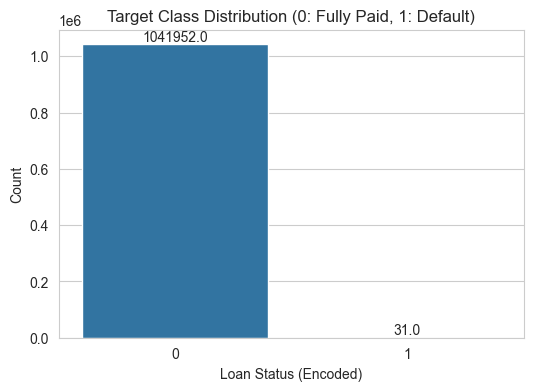

In [28]:
df_selected = df_selected_features[df_selected_features['loan_status'].isin(['Fully Paid','Default'])].copy()
mapping = {'Fully Paid': 0, 'Default': 1}
df_selected['loan_status'] = df_selected['loan_status'].map(mapping)

print("Encoded Loan Status Distribution (%):")
print(df_selected['loan_status'].value_counts(normalize=True) * 100)
print("\nEncoded Loan Status Distribution (count):")
print(df_selected['loan_status'].value_counts())

plt.figure(figsize=(6,4))
ax = sns.countplot(x='loan_status', data=df_selected)
plt.title('Target Class Distribution (0: Fully Paid, 1: Default)')
plt.xlabel('Loan Status (Encoded)')
plt.ylabel('Count')
for p in ax.patches:
  ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

target_variable = 'loan_status'
independent_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc']

#### 3.5. Handling Missing Values in Selected Features

In [9]:
print("Missing Values Before Handling:")
print(df_selected[independent_features].isnull().sum())

df_selected.dropna(subset=independent_features, inplace=True)
print("\nMissing Values After Row Removal (if any):")
print(df_selected[independent_features].isnull().sum())
print(f"\nDataset Size (After Handling Missing Values): {df_selected.shape}")

Missing Values Before Handling:
loan_amnt      0
int_rate       0
installment    0
annual_inc     0
dtype: int64

Missing Values After Row Removal (if any):
loan_amnt      0
int_rate       0
installment    0
annual_inc     0
dtype: int64

Dataset Size (After Handling Missing Values): (1041983, 5)


### 4. Feature Visualization

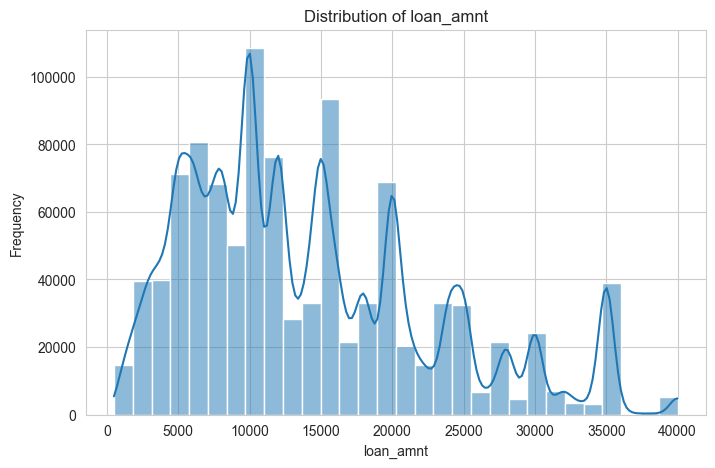

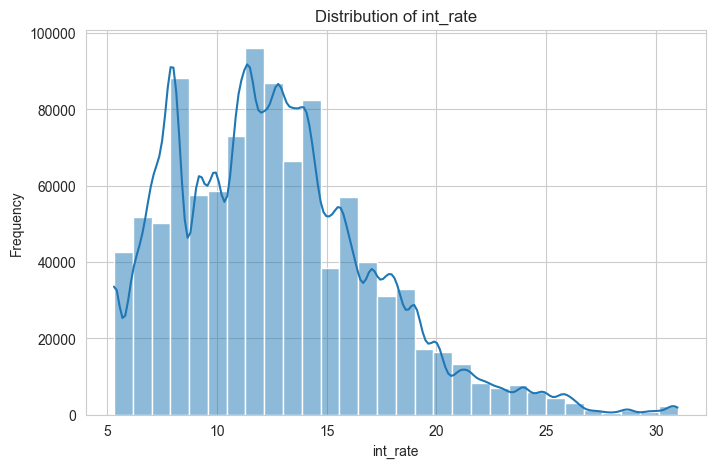

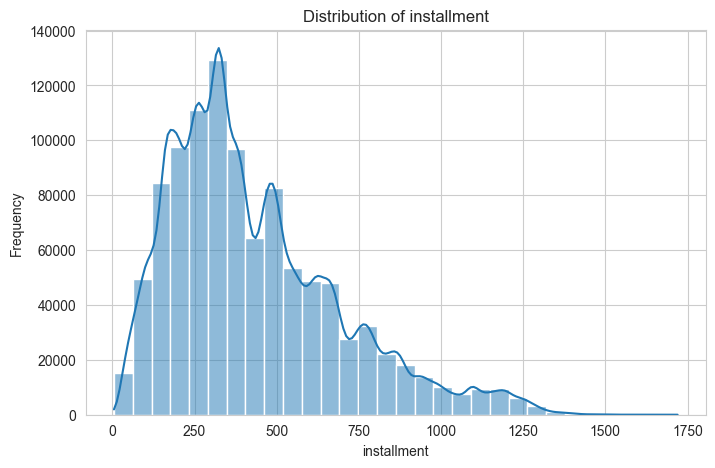

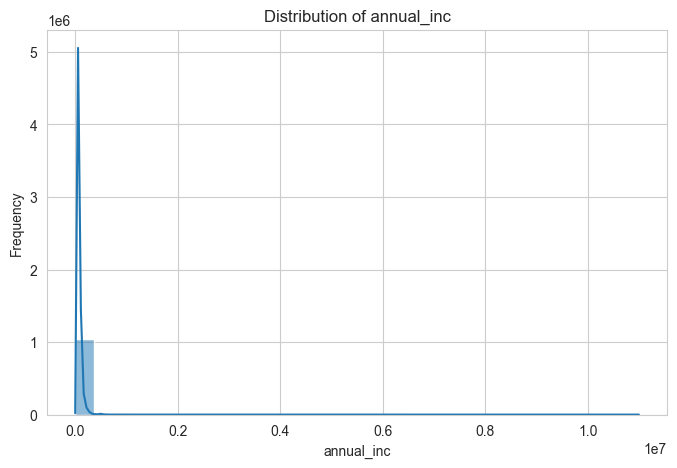

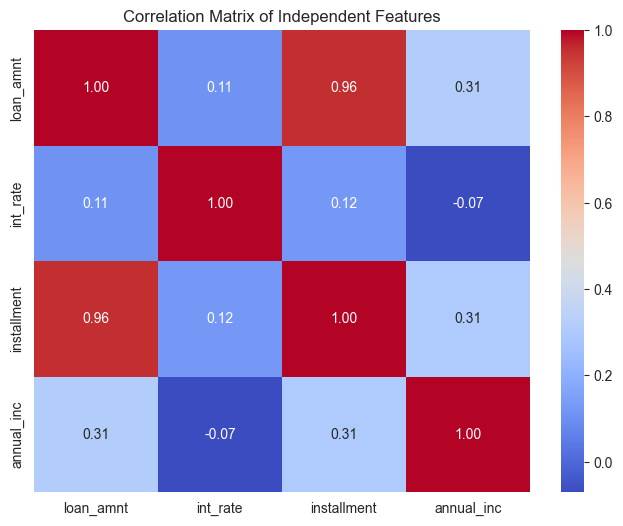

In [10]:
if not df_selected.empty and all(f in df_selected.columns for f in independent_features):
    for col in independent_features:
        plt.figure(figsize=(8, 5))
        sns.histplot(df_selected[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

    plt.figure(figsize=(8, 6))
    correlation_matrix = df_selected[independent_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Independent Features')
    plt.show()

In [ ]:
# df_selected['annual_inc_log'] = np.log1p(df_selected['annual_inc'])

# plt.subplot(1, 2, 2)
# sns.histplot(df_selected['annual_inc_log'], kde=True, bins=30)
# plt.title('Distribution of annual_inc after Logarithmic Transformation')
# plt.xlabel('Log(1 + Annual Income)')
# plt.ylabel('Frequency')

### 5. Data Preprocessing

#### 5.1. Data Splitting

In [29]:
target_variable = 'loan_status'
independent_features = ['loan_amnt', 'int_rate', 'installment', 'annual_inc']

X = df_selected[independent_features]
y = df_selected[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### 5.2. Check Class Composition in Splits

In [30]:
# Check composition and count of classes in 'y' after splitting
print("Class composition and counts in y_train:")
print(y_train.value_counts())
print("\nClass proportions in y_train (%):")
print(y_train.value_counts(normalize=True) * 100)

print("\nClass composition and counts in y_test:")
print(y_test.value_counts())
print("\nClass proportions in y_test (%):")
print(y_test.value_counts(normalize=True) * 100)

Class composition and counts in y_train:
loan_status
0    833561
1        25
Name: count, dtype: int64

Class proportions in y_train (%):
loan_status
0   99.997001
1    0.002999
Name: proportion, dtype: float64

Class composition and counts in y_test:
loan_status
0    208391
1         6
Name: count, dtype: int64

Class proportions in y_test (%):
loan_status
0   99.997121
1    0.002879
Name: proportion, dtype: float64


### 6. Handling Imbalanced Data with ADASYN


Class distribution in y_train before ADASYN: 
loan_status
0   0.999970
1   0.000030
Name: proportion, dtype: float64
loan_status
0    833561
1        25
Name: count, dtype: int64

Shape of X_train after ADASYN: (1667130, 4)
Class distribution in y_train after ADASYN: 
loan_status
1   0.500002
0   0.499998
Name: proportion, dtype: float64
loan_status
1    833569
0    833561
Name: count, dtype: int64

Visualizing ADASYN results with PCA (2 components)...


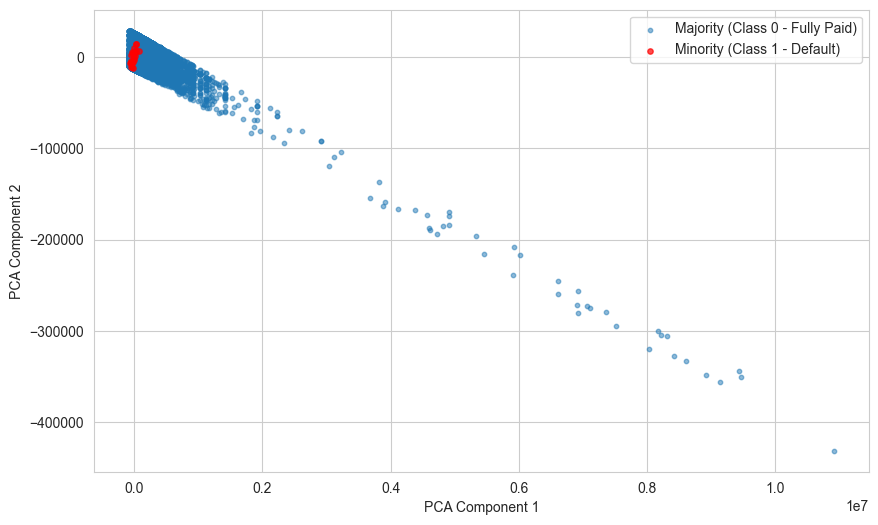

c:\DATA\Python\EDA\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


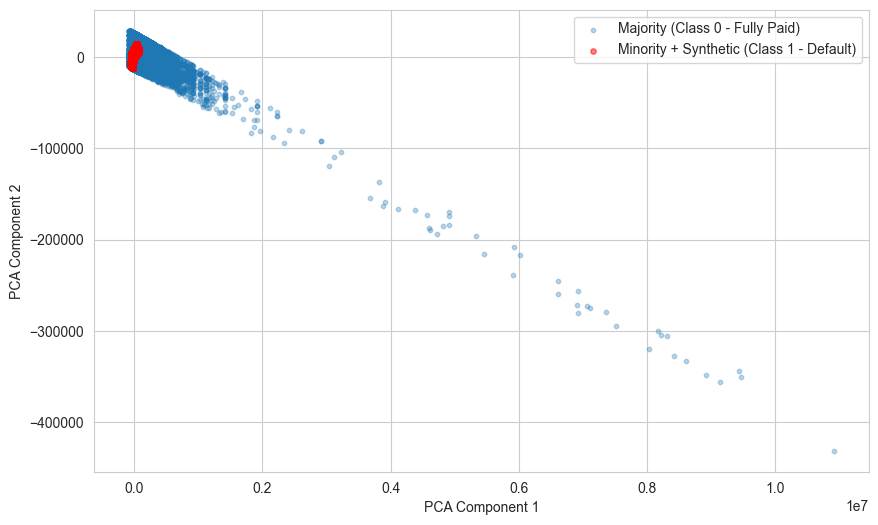

In [ ]:
print(f"\nClass distribution in y_train before ADASYN: \n{y_train.value_counts(normalize=True)}")
print(y_train.value_counts())

# Save X_train_scaled and y_train before ADASYN for PCA visualization
X_train_scaled_before_adasyn = X_train.copy()
y_train_before_adasyn = y_train.copy()

# ADASYN parameters (K=5 for n_neighbors)
adasyn = ADASYN(random_state=420, n_neighbors=5) # n_neighbors=5 is the default
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

print(f"\nShape of X_train after ADASYN: {X_train_resampled.shape}")
print(f"Class distribution in y_train after ADASYN: \n{pd.Series(y_train_resampled).value_counts(normalize=True)}")
print(y_train_resampled.value_counts())

# --- Visualize ADASYN Results with PCA ---
print("\nVisualizing ADASYN results with PCA (2 components)...")
pca = PCA(n_components=2)

# Apply PCA to training data BEFORE ADASYN
X_train_pca_before = pca.fit_transform(X_train_scaled_before_adasyn)

# Apply PCA to training data AFTER ADASYN
if isinstance(X_train_resampled, np.ndarray):
    X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train.columns)
else:
    X_train_resampled_df = X_train_resampled

X_train_pca_after = pca.transform(X_train_resampled_df) # Use transform as PCA is already fitted

# plt.figure(figsize=(14, 7))

# Plot before ADASYN
plt.scatter(X_train_pca_before[y_train_before_adasyn == 0, 0], X_train_pca_before[y_train_before_adasyn == 0, 1], label='Majority (Class 0 - Fully Paid)', alpha=0.5, s=10)
plt.scatter(X_train_pca_before[y_train_before_adasyn == 1, 0], X_train_pca_before[y_train_before_adasyn == 1, 1], label='Minority (Class 1 - Default)', alpha=0.7, s=15, c='red')
plt.title('Training Data Before ADASYN (PCA 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Plot after ADASYN
num_original_minority_before = (y_train_before_adasyn == 1).sum()
num_original_majority_before = (y_train_before_adasyn == 0).sum()

plt.scatter(X_train_pca_after[y_train_resampled == 0, 0], X_train_pca_after[y_train_resampled == 0, 1], label='Majority (Class 0 - Fully Paid)', alpha=0.3, s=10)
plt.scatter(X_train_pca_after[y_train_resampled == 1, 0], X_train_pca_after[y_train_resampled == 1, 1], label='Minority + Synthetic (Class 1 - Default)', alpha=0.5, s=15, c='red')

plt.title('Training Data After ADASYN (PCA 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
# plt.tight_layout()
plt.show()

### 7. Feature Scaling

In [32]:
loan_amnt_col = ['loan_amnt']
other_cols = ['int_rate', 'installment', 'annual_inc']

min_max_scaler_loan_amnt = MinMaxScaler(feature_range=(-1, 1))
scaler_others = RobustScaler()

X_train_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

X_train_scaled[loan_amnt_col] = min_max_scaler_loan_amnt.fit_transform(X_train_resampled[loan_amnt_col])
X_test_scaled[loan_amnt_col] = min_max_scaler_loan_amnt.transform(X_test[loan_amnt_col])

if other_cols: # Ensure other_cols is not empty
    X_train_scaled[other_cols] = scaler_others.fit_transform(X_train_resampled[other_cols])
    X_test_scaled[other_cols] = scaler_others.transform(X_test[other_cols])

print("\nDescriptive statistics of X_train_scaled:")
print(X_train_scaled.describe())


Descriptive statistics of X_train_scaled:
           loan_amnt       int_rate    installment     annual_inc
count 1667130.000000 1667130.000000 1667130.000000 1667130.000000
mean       -0.318962       0.124080       0.144211       0.135201
std         0.414284       0.778733       0.777845       1.151081
min        -1.000000      -1.287814      -1.143676      -1.336736
25%        -0.661823      -0.404874      -0.438914      -0.461736
50%        -0.379747       0.000000       0.000000       0.000000
75%        -0.043342       0.595126       0.561086       0.538264
max         1.000000       2.493295       3.940867     227.813264


### 8. Deep Neural Network (DNN) Modeling

#### 8.1. Define DNN Architecture

In [33]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)), # Input shape based on number of features
    Dense(64, activation='relu'),
    Dropout(0.3), # Adding Dropout for regularization
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification output
])

# Compile the model
# Optimizer: Adam, Loss: binary_crossentropy (for binary classification)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', tf.keras.metrics.AUC(name='auc')])

model.summary()

# Callback for Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

#### 8.2. Train the DNN Model

In [34]:
print("\nStarting DNN model training...")
history = model.fit(
    X_train_scaled, y_train_resampled, # Use ADASYN-resampled data
    epochs=100,
    batch_size=32,
    validation_split=0.2, # Use 20% of training data for validation
    callbacks=[early_stopping],
    verbose=1
)
print("Model training finished.")


Starting DNN model training...
Epoch 1/100
41679/41679 ━━━━━━━━━━━━━━━━━━━━ 162s 4ms/step - Precision: 0.7993 - Recall: 0.8534 - accuracy: 0.8655 - auc: 0.9349 - loss: 0.2966 - val_Precision: 1.0000 - val_Recall: 0.7448 - val_accuracy: 0.7448 - val_auc: 0.0000e+00 - val_loss: 0.7105
Epoch 2/100
41679/41679 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - Precision: 0.8740 - Recall: 0.9545 - accuracy: 0.9314 - auc: 0.9753 - loss: 0.1834 - val_Precision: 1.0000 - val_Recall: 0.7440 - val_accuracy: 0.7440 - val_auc: 0.0000e+00 - val_loss: 0.7676
Epoch 3/100
41679/41679 ━━━━━━━━━━━━━━━━━━━━ 165s 4ms/step - Precision: 0.8829 - Recall: 0.9585 - accuracy: 0.9366 - auc: 0.9782 - loss: 0.1718 - val_Precision: 1.0000 - val_Recall: 0.7447 - val_accuracy: 0.7447 - val_auc: 0.0000e+00 - val_loss: 0.7164
Epoch 4/100
41679/41679 ━━━━━━━━━━━━━━━━━━━━ 210s 4ms/step - Precision: 0.8883 - Recall: 0.9628 - accuracy: 0.9405 - auc: 0.9801 - loss: 0.1630 - val_Precision: 1.0000 - val_Recall: 0.7303 - val_accuracy: 0.73

#### 8.3. Plot Training History
Visualize the model's training and validation accuracy and loss over epochs.

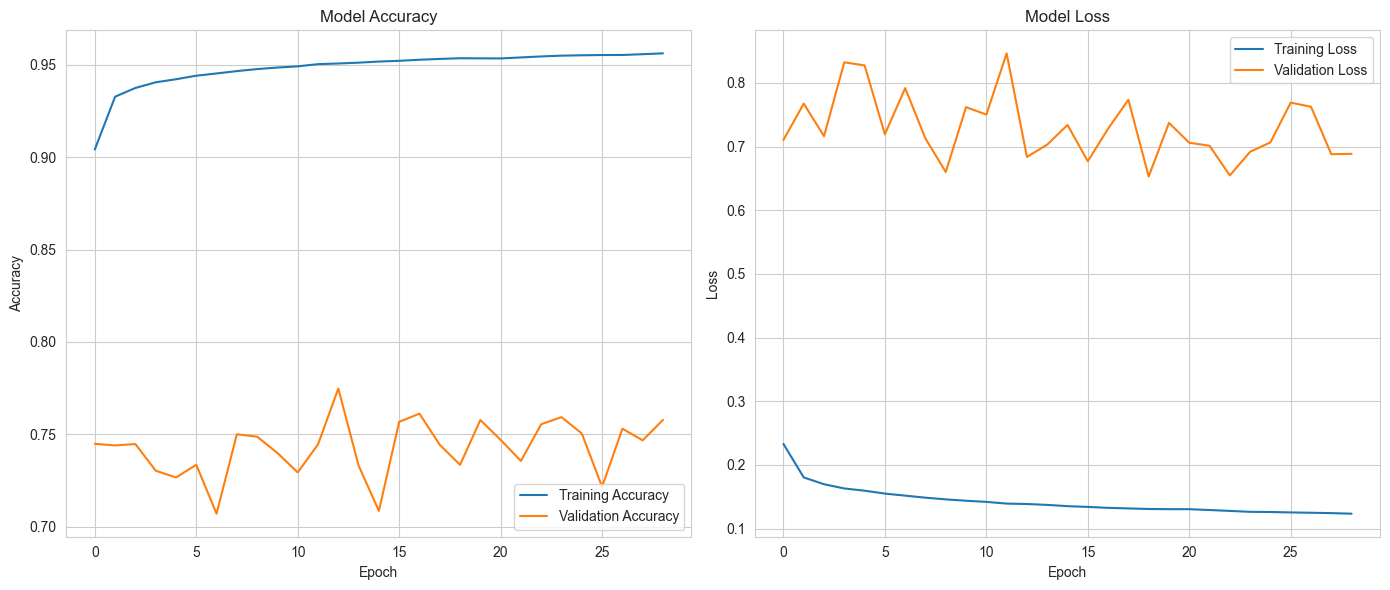

In [35]:
if history is not None:
    plt.figure(figsize=(14, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

### 9. Model Evaluation

#### 9.1. Evaluation

In [29]:
model.evaluate(X_test_scaled, y_test, verbose=1)
# print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


6513/6513 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - Precision: 5.0202e-05 - Recall: 0.0999 - accuracy: 0.9414 - auc: 0.3630 - loss: 0.1237


[0.13343122601509094,
 0.9407908916473389,
 8.107012399705127e-05,
 0.1666666716337204,
 0.4959923028945923]

#### 9.1. Prediction

6513/6513 ━━━━━━━━━━━━━━━━━━━━ 4s 568us/step

--- MODEL EVALUATION RESULTS ---
Accuracy : 0.9515
Precision : 0.0001
Recall : 0.1667
Specificity : 0.9516
F1 Score : 0.0002

Confusion Matrix:
[[198295  10096]
 [     5      1]]


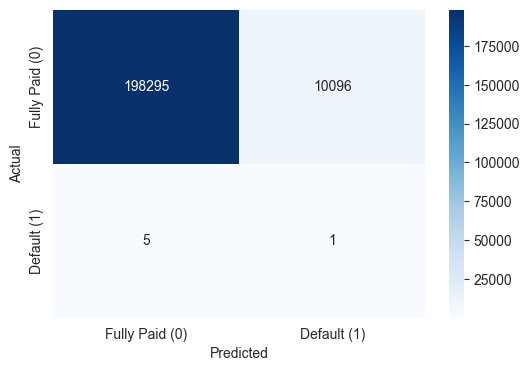


Classification Report:
                precision    recall  f1-score   support

Fully Paid (0)       1.00      0.95      0.98    208391
   Default (1)       0.00      0.17      0.00         6

      accuracy                           0.95    208397
     macro avg       0.50      0.56      0.49    208397
  weighted avg       1.00      0.95      0.98    208397



In [42]:
# Predictions on the test set
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int) 
# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

cm = confusion_matrix(y_test, y_pred)

# Ensure cm has 4 elements before unpacking (tn, fp, fn, tp)
if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
else: # Handle cases where the confusion matrix might not be 2x2 (e.g., if one class has no predictions)
    print("Warning: Confusion matrix is not 2x2. Specificity might not be directly calculable or meaningful.")
    print(f"Confusion Matrix shape: {cm.shape}")
    print(f"y_test unique values and counts: {np.unique(y_test, return_counts=True)}")
    print(f"y_pred unique values and counts: {np.unique(y_pred, return_counts=True)}")
    # Set specificity to NaN or a default value if it cannot be calculated
    specificity = np.nan
    # If only one class is predicted, tn or tp might be the total count for that class, and the other pair (fp, fn) would be zero.
    # For example, if only class 0 is predicted: tn = sum(y_test==0), fp = 0, fn = sum(y_test==1), tp = 0.
    # Or if only class 1 is predicted: tn = 0, fp = sum(y_test==0), fn = 0, tp = sum(y_test==1).
    if len(np.unique(y_pred)) == 1:
        if np.unique(y_pred)[0] == 0: # All predicted as class 0
            tn = cm[0,0] if cm.shape == (1,1) or (cm.shape[0] > 0 and cm.shape[1] > 0) else np.sum(y_test==0) # approximation
            fp = 0
            specificity = 1.0 if tn > 0 else 0 # Or based on actual tn/(tn+fp)
        elif np.unique(y_pred)[0] == 1: # All predicted as class 1
            tn = 0
            fp = np.sum(y_test==0) # approximation
            specificity = 0.0

print("\n--- MODEL EVALUATION RESULTS ---")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"Specificity : {specificity:.4f}")
print(f"F1 Score : {f1:.4f}")

print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid (0)', 'Default (1)'],
            yticklabels=['Fully Paid (0)', 'Default (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
# plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fully Paid (0)', 'Default (1)']))